# **Нейросетевая классификация объектов**
------------

Попробуем применить tf для решения задачи классификации ирисов

## **Библиотека tensorflow. Основные решаемые задачи**
---



Мы научились рассчитывать и обучать многослойные нейросети. Но решаемая задача была очень простой. Практические задачи, которые сейчас решают нейросети, очень разнообразны и требуют и более мощной обработки и более сложного обучения. 

Поэтому реализация нейросетей с использованием библиотеки типа **numpy** становится громоздкой и неудобной.

----

Что нам надо чтобы смоделировать многослойную полносвязную нейросеть с последовательными слоями?

- задать параметры входного слоя (размерность тензора на входе нейросети);

- задать количество слоев;

- задать количество нейронов в каждом слое;

- задать функцию активации в каждом слое;

- задать способ инициализации весов (в каждом слое);

Что нам надо, чтобы обучить нейросеть (с использованием SGD  или других методов оптимизации, которые мы рассмотрим позднее):

- задать метод оптимизации;

- задать критерий оптимизации;

- задать размер пакета;

- задать шаг обучения;

- задать коэффициент регуляризации;

----

все остальное, мы хотели бы, чтобы рассчитывалось автоматически, с использованием указанных паарметров:

- обучение нейросети с использованием обучающей (и валидационной выборки);

- расчет нейросети на новых данных;

---

Также важно, чтобы библиотека поддерживала расширение видов слоев и способов их комбинаций.


### **tensorflow - библиотека по обработке тензоров**
----------



Если мы внимательно посмотрим на нейросетевую обработку данных, то увидим, что она формирует поток тензоров - массивов произвольной размерности.

Действительно - на вход нейросети подается тензор входных данных размерности: 
$$(batch\_size, data\_size)$$
или если это картинка, то:

$$(batch\_size, width, height, canals)$$

Что происходит при расчете слоя с этим тензором?

- он умножается на другой тензор - матрицу весов и получается новый тензор;

- он пропускается через функцию активации и получается опять тензор;

то же самое происходит и при расчете градиента: 
- тензор на выходе нейросети пропускается через производную функции активации; 

- умножается на матрицу весов (транспонированную) или умножается на вектор выходов предыдущего слоя;

-----

если мы рассчитываем и обучаем другие виды нейросетей, то тензора могут конкатенироваться, складываться, изменять размер, ...

----

т.е. нас интересует организация некоторого алгоритма расчета, в котором переменными являются тензоры.

--- 

проиллюстрируем как библиотека tf решает эту задачу

см. https://www.tensorflow.org/guide/


### 1. Создание тензоров и связь с numpy.array
-------

см. https://www.tensorflow.org/guide/tensor


### 2. Создание переменных тензоров
----

см. https://www.tensorflow.org/guide/variable



### 3. Вычисление градиентов
-----

см. https://www.tensorflow.org/guide/autodiff

### 4. Keras
-----

Если мы хотим пользоваться известными архитектурами нейросетей, известными и распространенными моделями слоев, то нам достаточно использовать надстройку над tf - библиотеку Keras.

см. https://www.tensorflow.org/api_docs/python/tf/keras

С помощью данной библиотеки мы можем собрать и обучить нейросеть "на коленке"

Более подробно с данной библиотекой мы будем разбираться в следующих темах. А сейчас продемонстрируем как можно ее использовать для решения нашей демонстрационной задачи - сети, моделирующей операцию XOR (рис.1)

## ПРИМЕР применения для решения задачи XOR
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt   # библиотека построения графиков
plt.style.use('ggplot')   # устанавливаем стиль построения графиков

import tensorflow as tf

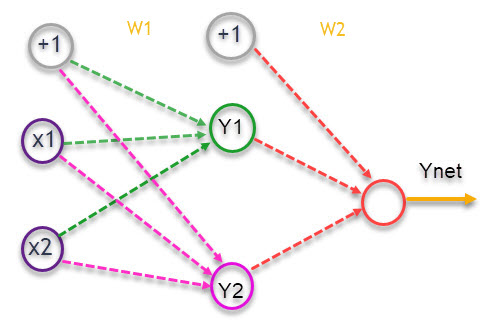

Рис. 1. Схематическая модель нейросети, реализующей операцию XOR

### **Обучающая выборка для XOR-нейросети**

---------


In [2]:
# Обучающая выборка
random_state = 42
np.random.seed(random_state)
# сгенерируем множество nn точек x из нормального распределения с центром в A и СКО sigma
def genX(point, sigma=1.0, nn=10):
    X = point + sigma*np.random.randn(nn, 2)
    return X

nn = 10
sigma = 0.1
# сгенерируем "нули"
A = np.array([0.0, 0.0])
C = np.array([1.0, 1.0])
X0 = np.vstack([genX(A, sigma=sigma, nn=nn), genX(C, sigma=sigma, nn=nn)])
y0 = np.zeros(2*nn)

# сгенерируем "единицы"
B = np.array([1.0, 0.0])
D = np.array([0.0, 1.0])
X1 = np.vstack([genX(B, sigma=sigma, nn=nn), genX(D, sigma=sigma, nn=nn)])
y1 = np.ones(2*nn)

X = np.vstack([X0,X1])
y = np.hstack([y0, y1])
print(X.shape)
print(y)

(40, 2)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


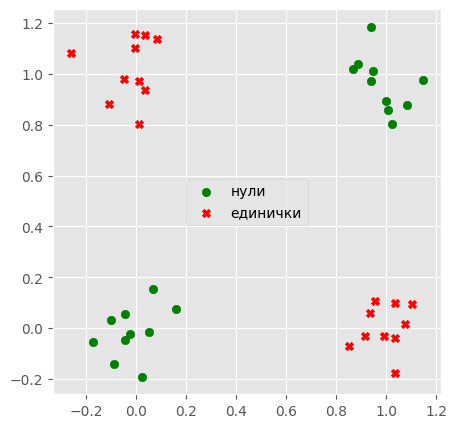

In [3]:
# отобразим графически расположение точек и границ
plt.figure(figsize=(5,5))
plt.scatter(X[y==0].T[0], X[y==0].T[1], c='g', marker='o', label='нули')
plt.scatter(X[y==1].T[0], X[y==1].T[1], c='r', marker='X', label='единички')
#plt.xlim(-2, 4)
plt.legend(loc= 'center');

In [4]:
# Описываем слои нейросети
inputs = tf.keras.Input(shape=(2,))
x = tf.keras.layers.Dense(2, activation=tf.nn.relu)(inputs) # , kernel_initializer='he_uniform', kernel_regularizer= tf.keras.regularizers.L2(0.00001)
outputs = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x) # , kernel_regularizer= tf.keras.regularizers.L2(0.00001)

# Собираем модель нейросети
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [9]:
ypred = model.predict(X)
print(np.round(ypred.T))
# print(X)
print(y)

2/2 [==============================] - 0s 2ms/step
[[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [10]:
# компилируем нейросеть для обучения
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse', metrics=['mae','acc'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


#### **Обучение модели**
-------------


In [14]:
hist = model.fit(x=X, y=y, batch_size=4, epochs=200, verbose=0)

In [27]:
print(f"loss = {hist.history['loss'][-1]}\nmae = {hist.history['mae'][-1]}\nacc = {hist.history['acc'][-1]}")

loss = 3.247833956265822e-05
mae = 0.004256926476955414
acc = 1.0


In [9]:
#dir(model)
model.get_weights()

[array([[-1.9667852, -4.313255 ],
        [ 2.0938706,  4.1976585]], dtype=float32),
 array([ 1.7046776 , -0.11154164], dtype=float32),
 array([[-4.16554  ],
        [ 4.4250207]], dtype=float32),
 array([2.6680355], dtype=float32)]

In [10]:
ypred = model.predict(X)
ypred.T - y

2/2 [==============================] - 0s 3ms/step


array([[ 0.01973696,  0.01580624,  0.01188542,  0.02170164,  0.02022398,
         0.01205297,  0.07136872,  0.02656079,  0.02893068,  0.01898459,
         0.02753014,  0.02498339,  0.00514268,  0.01282639,  0.00548676,
         0.02968772,  0.01711127,  0.03828995,  0.0438606 ,  0.01304118,
        -0.06488609, -0.06488609, -0.06488609, -0.07867885, -0.06488609,
        -0.06488609, -0.06488609, -0.06488609, -0.06488609, -0.06488609,
        -0.00514156, -0.0070141 , -0.00459898, -0.00248903, -0.0199061 ,
        -0.0023573 , -0.00149101, -0.00018597, -0.01059461, -0.05376107]])

In [ ]:
# сохранение модели
model.save()

## Применим tf для решения задачи классификации ИРИСОВ
---


In [ ]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# импортируем функцию деления выборки и классификаторы
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn import datasets
import seaborn as sns

iris = datasets.load_iris()

iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df['Species'] = np.array([iris.target_names[cls] for cls in iris.target])
sns.pairplot(iris_df, hue='Species');

In [40]:
iris_df.tail(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


In [41]:
# классы ирисов
set(iris_df['Species']), set(iris.target)

({'setosa', 'versicolor', 'virginica'}, {0, 1, 2})

In [42]:
# упростим задачу, сделаем только два класса
y_true = iris.target
y_true[y_true == 2] = 1
set(y_true)

{0, 1}

In [43]:
# подготовим данные
x_train, x_test, y_train, y_test = train_test_split(
    iris.data, y_true,
    test_size=0.3, stratify= iris.target, random_state=42
)

In [44]:
x_train.shape, y_train.shape, y_test[:5]

((105, 4), (105,), array([1, 1, 0, 1, 0]))

### Обучаем модель на выборке x_train, y_train
---

In [50]:
# Описываем слои нейросети
inputs = tf.keras.Input(shape=(4,))
x = tf.keras.layers.Dense(2, activation=tf.nn.relu)(inputs) # , kernel_initializer='he_uniform', kernel_regularizer= tf.keras.regularizers.L2(0.00001)
outputs = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x) # , kernel_regularizer= tf.keras.regularizers.L2(0.00001)

# Собираем модель нейросети
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [51]:
ypred = model.predict(x_train)
print(np.round(y_train.T))
print(np.round(ypred.T))
# print(X)


4/4 [==============================] - 0s 2ms/step
[1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1
 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 0]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [52]:
# компилируем нейросеть для обучения
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse', metrics=['mae','acc'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_8 (Dense)             (None, 2)                 10        
                                                                 
 dense_9 (Dense)             (None, 1)                 3         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [53]:
hist = model.fit(x=x_train, y=y_train, batch_size=5, epochs=1000, verbose=0)

In [54]:
print(f"loss = {hist.history['loss'][-1]}\nmae = {hist.history['mae'][-1]}\nacc = {hist.history['acc'][-1]}")

loss = 1.5267906050553393e-08
mae = 7.279455167008564e-05
acc = 1.0


In [55]:
#dir(model)
model.get_weights()

[array([[-0.57751113, -0.1463008 ],
        [-1.0123483 , -0.64234257],
        [ 3.1457129 ,  0.37121606],
        [ 3.4883485 , -0.626004  ]], dtype=float32),
 array([-0.54738814,  0.        ], dtype=float32),
 array([[ 2.3265064 ],
        [-0.42515445]], dtype=float32),
 array([-8.471871], dtype=float32)]

In [56]:
ypred = model.predict(x_train)
ypred.T - y_train

4/4 [==============================] - 0s 2ms/step


array([[ 0.00000000e+00,  2.09229111e-04,  0.00000000e+00,
         2.09229111e-04,  2.09229111e-04,  2.09229111e-04,
         2.09229111e-04,  2.09229111e-04,  2.09229111e-04,
         0.00000000e+00,  0.00000000e+00, -3.70740891e-05,
         2.09229111e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.19209290e-07, -1.19209290e-07,
         0.00000000e+00,  2.09229111e-04,  2.09229111e-04,
         0.00000000e+00,  2.09229111e-04,  0.00000000e+00,
         0.00000000e+00,  2.09229111e-04,  2.09229111e-04,
         2.09229111e-04,  0.00000000e+00, -5.96046448e-07,
         0.00000000e+00,  0.00000000e+00,  2.09229111e-04,
         2.09229111e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.09229111e-04, -5.36441803e-07,
         2.09229111e-04,  0.00000000e+00,  2.09229111e-04,
         0.00000000e+00,  0.00000000e+00, -2.74181366e-06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.09229111e-04,  0.00000000e+00, -3.51667404e-0

### Проверяем точность модели на выборке x_test, y_test
---

In [58]:
# acc_3 = accuracy_score(y_test, model.predict(x_test))
# F1_3 = f1_score(y_test, model.predict(x_test), average=None)

acc_3 = accuracy_score(y_test, np.round(model.predict(x_test)))
F1_3 = f1_score(y_test, np.round(model.predict(x_test)), average=None)
print('test accuracy for model:', round(acc_3, 3))
print('test F1 for model:', np.round(F1_3, 3))

2/2 [==============================] - 0s 2ms/step
test accuracy for model: 1.0
test F1 for model: [1. 1.]
